In [1]:
import pandas as pd
import numpy as np 
import math
import scipy
import scipy.stats as stats
from sklearn import datasets, linear_model
from sklearn.preprocessing import MinMaxScaler
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import csv
import tensorflow.compat.v1 as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping,LearningRateScheduler
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM, GRU
from keras.models import Sequential
from keras import optimizers

In [2]:
# 1 Reading data
df = pd.read_csv('datatraining.txt', dayfirst=True, parse_dates=['date'])

In [3]:
# 2. Data Re-sampling
df = df.set_index('date')
df = df.resample('5T').mean()
df['Occupancy'] = np.where(df['Occupancy'] < 0.5, 0, df['Occupancy'])
df['Occupancy'] = np.where(df['Occupancy'] >= 0.5, 1, df['Occupancy'])
df['Occupancy'] = df['Occupancy'].astype(np.int64)

In [4]:
print(df.head())

                     Temperature   Humidity    Light         CO2   
date                                                               
2015-02-04 17:50:00    23.157500  27.246125  426.875  714.250000  \
2015-02-04 17:55:00    23.100000  27.200000  420.400  699.100000   
2015-02-04 18:00:00    23.066667  27.144444  419.000  687.708333   
2015-02-04 18:05:00    22.972500  27.251250  104.625  683.000000   
2015-02-04 18:10:00    22.890000  27.423000    0.000  689.300000   

                     HumidityRatio  Occupancy  
date                                           
2015-02-04 17:50:00       0.004782          1  
2015-02-04 17:55:00       0.004757          1  
2015-02-04 18:00:00       0.004738          1  
2015-02-04 18:05:00       0.004729          0  
2015-02-04 18:10:00       0.004735          0  


In [5]:
# 3. Min-Max normalization
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df.drop(['Occupancy'],axis=1))
normalized_target = scaler.fit_transform(df[['Occupancy']])

print(normalized_data)
print(normalized_target)
# print(df)

# df.plot(figsize=(12,6))
# plt.show()

[[1.         0.46862707 0.45865193 0.18495314 0.55588867]
 [0.98600122 0.46655608 0.45169493 0.17553979 0.54929555]
 [0.97788598 0.46406166 0.45019071 0.16846166 0.54414594]
 ...
 [0.47306756 0.84927787 0.46523289 0.19868741 0.74664497]
 [0.48326233 0.86124546 0.46523289 0.22472946 0.76145422]
 [0.49908704 0.86997842 0.47024694 0.24648337 0.77546914]]
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


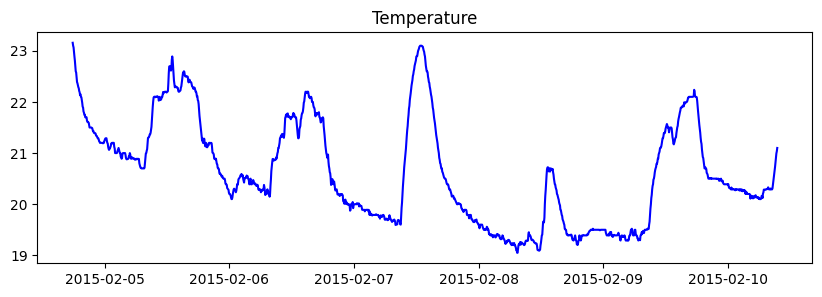

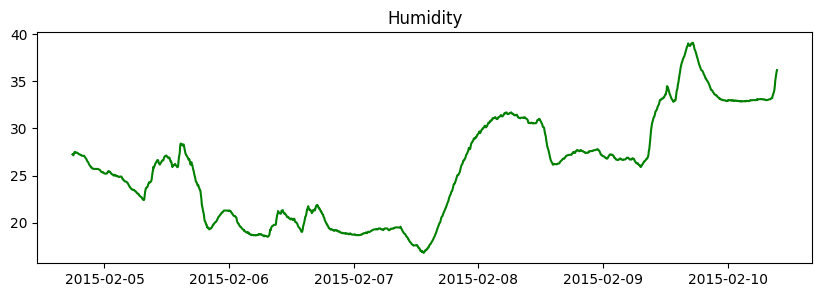

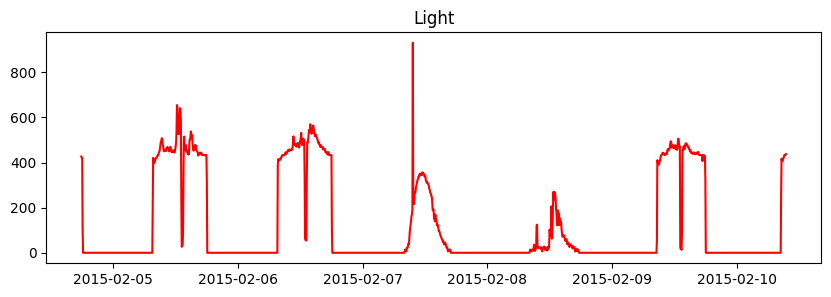

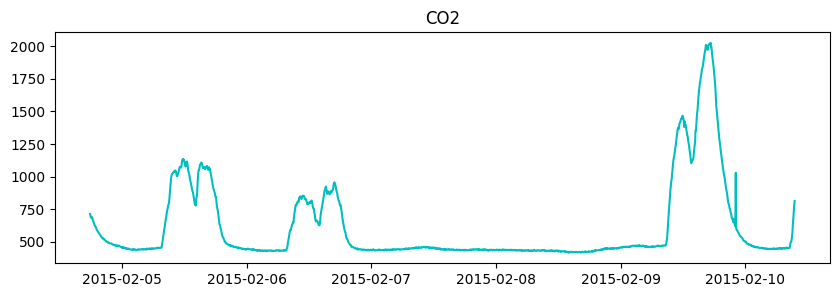

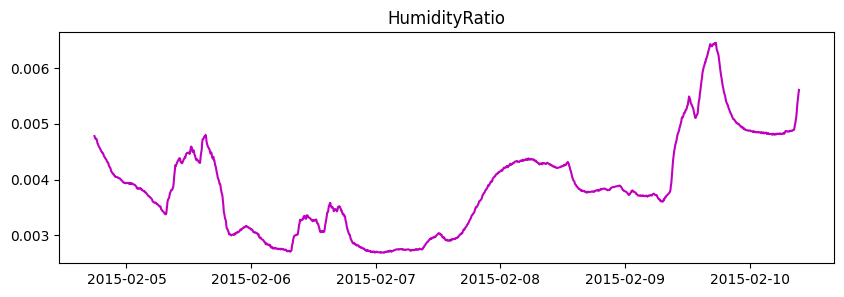

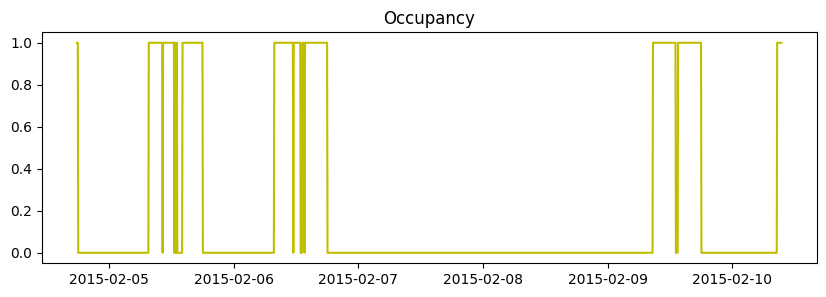

In [6]:
columns = list(df.columns)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, column in enumerate(columns):
    plt.figure(figsize = (10,3))
    plt.plot(df[column], color= colors[i%len(colors)])
    plt.title(column)
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(normalized_data, normalized_target,
                                                    test_size=0.2, random_state=1)

# Reshape input data
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


In [9]:

# design network
model = Sequential()
model.add(GRU(64, activation='relu', return_sequences=True, input_shape=(1,X_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


print ('model compiled')
print (model.summary())

model compiled
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 64)             13632     
                                                                 
 dropout (Dropout)           (None, 1, 64)             0         
                                                                 
 gru_1 (GRU)                 (None, 128)               74496     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 88,257
Trainable params: 88,257
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
#Train the model

#model.fit(X_train, y_train, epochs=20, batch_size=12, verbose=0)

In [11]:
# Set up early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

#Train the model with early stopping
history = model.fit(X_train, y_train, epochs=20, batch_size=11, verbose=0, 
                    validation_data=(X_test, y_test), callbacks=[early_stop])


In [12]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# Evaluate model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test,y_pred)
r2 = r2_score(y_test, y_pred)
print(f"LSTM model R-squared: {r2}")
print(f"LSTM model RMSE: {rmse}")
print(f"LSTM model MAE: {mae}")

11/11 [==============================] - 1s 2ms/step
LSTM model R-squared: 0.9642371171947449
LSTM model RMSE: 0.08270770798285171
LSTM model MAE: 0.025917300748770224


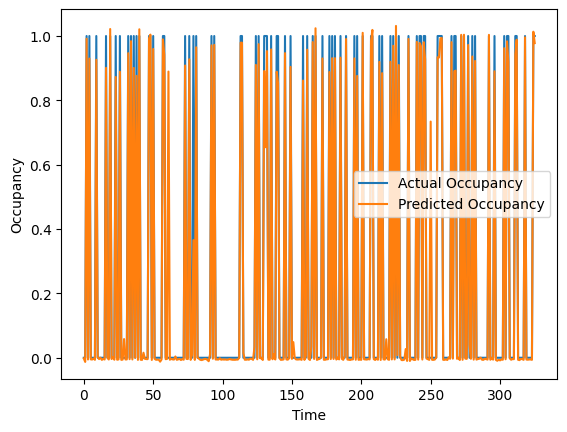

In [13]:
plt.plot(y_test, label='Actual Occupancy', linewidth=1.5)
plt.plot(y_pred, label='Predicted Occupancy', linewidth=1.5)
plt.xlabel('Time')
plt.ylabel('Occupancy')
plt.legend()
plt.show()